## 1. Importaciones

In [1]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [2]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [3]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

    gsync = utils.GDriveSync()


try:
    from allconv import AllConvNet
except ModuleNotFoundError:
    !wget https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
    from allconv import AllConvNet

--2023-11-07 13:01:35--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.41K  --.-KB/s    in 0s      

2023-11-07 13:01:36 (60.1 MB/s) - ‘utils.py’ saved [4519/4519]

--2023-11-07 13:01:59--  https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/StefOe/all-conv-pytorch/8545bb3ff7ac4410e52d8db930f0485074073ea9/allconv.py [following]
--2023-11-07 13:02:00--  https://raw.

## 2. Transformacion y carga de datos

In [4]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()

trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255


# Data normal (32x32)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_train8x8 = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


100%|██████████| 170498071/170498071 [00:03<00:00, 42962404.76it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)


Files already downloaded and verified


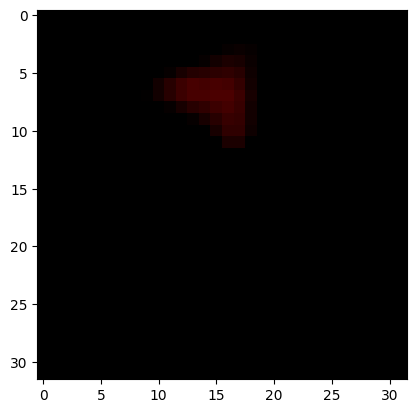

In [7]:
for batch_data, batch_labels in train_loader_blur:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

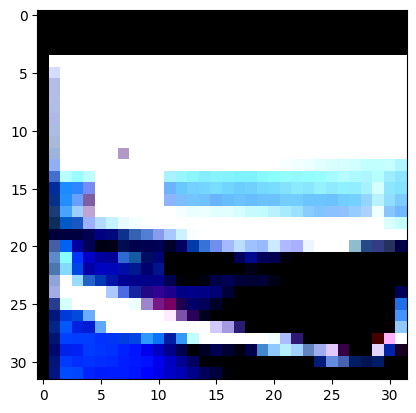

In [8]:
for batch_data, batch_labels in train_loader:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

## 3. Entrenamiento

In [9]:
model = AllConvNet(3)
if cuda:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[200, 250, 300], gamma=0.1)

In [12]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def blur_train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_blur):
        if cuda:
            data, target = data.cuda(), target.cuda() # Pasar la data a la GPU
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad() # Seteo en 0 los valores de los gradientes
        output = model(data) # Hago forward
        loss = criterion(output, target) # Se calcula la CrossEntropyLoss
        loss.backward()
        optimizer.step() # Actualización de los parámetros

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def test(epoch, best_loss, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100. * correct /
            len(test_loader.dataset)))

    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss
        torch.save(model, "best.pt")
        if gsync_save:
            gsync.update_file_to_folder("best.pt")
    return best_loss, best_epoch

In [20]:
def begin_model(n_epochs: int, blur_epochs: int, blur_start: int):
  best_loss = float("inf")
  best_epoch = -1

  if n_epochs <  blur_epochs + blur_start:
    print('ERROR: parámetros inconsistentes')

  else:
    if blur_start == 0:

      print(f''' {'*'*30}
      Blurred image Training begin
                 {'*'*30}
      ''')

      for epoch in range(blur_epochs):
        scheduler.step()
        blur_train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training End. Training with normal images
                 {'*'*30}
      ''')

      for epoch in range(blur_start + blur_epochs, n_epochs):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)


    elif blur_start != 0:

      for epoch in range(blur_start):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training begin
                 {'*'*30}
      ''')

      for epoch in range(blur_start, blur_start + blur_epochs):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training End. Training with normal images
                 {'*'*30}
      ''')

      for epoch in range(blur_start + blur_epochs, n_epochs):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

In [22]:
begin_model(n_epochs=5, blur_epochs=1, blur_start=2)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.303426
Train Epoch: 0 [3200/50000 (6%)]	Loss: 2.301904
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.303166
Train Epoch: 0 [9600/50000 (19%)]	Loss: 2.302562
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.302717
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.301476
Train Epoch: 0 [19200/50000 (38%)]	Loss: 2.302559
Train Epoch: 0 [22400/50000 (45%)]	Loss: 2.302887
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.303017
Train Epoch: 0 [28800/50000 (58%)]	Loss: 2.303121
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.302105
Train Epoch: 0 [35200/50000 (70%)]	Loss: 2.301988
Train Epoch: 0 [38400/50000 (77%)]	Loss: 2.301359
Train Epoch: 0 [41600/50000 (83%)]	Loss: 2.304173
Train Epoch: 0 [44800/50000 (90%)]	Loss: 2.303765
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.303158

Test set: Average loss: 0.0186, Accuracy: 1122/10000 (11%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 74.89it/s]


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302464
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.301512
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.302392
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.299674
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.301609
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.303283
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.301216
Train Epoch: 1 [22400/50000 (45%)]	Loss: 2.303541
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.302678
Train Epoch: 1 [28800/50000 (58%)]	Loss: 2.302315
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.300914
Train Epoch: 1 [35200/50000 (70%)]	Loss: 2.304406
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.302978
Train Epoch: 1 [41600/50000 (83%)]	Loss: 2.302028
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.303169
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.302046

Test set: Average loss: 0.0186, Accuracy: 1042/10000 (10%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 80.78it/s]

 ******************************
      Blurred image Training begin

      ******************************
      


Train Epoch: 2 [0/50000 (0%)]	Loss: 2.304267
Train Epoch: 2 [3200/50000 (6%)]	Loss: 2.301482
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.302687
Train Epoch: 2 [9600/50000 (19%)]	Loss: 2.302382
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.303570
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.297655
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.302156
Train Epoch: 2 [22400/50000 (45%)]	Loss: 2.301665
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.299475
Train Epoch: 2 [28800/50000 (58%)]	Loss: 2.300481
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.305017
Train Epoch: 2 [35200/50000 (70%)]	Loss: 2.301507
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.296222
Train Epoch: 2 [41600/50000 (83%)]	Loss: 2.297585
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.295449
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.293576

Test set: Average loss: 0.0186, Accuracy: 1019/10000 (10%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 62.51it/s]

 ******************************
      Blurred image Training End. Training with normal images

      ******************************
      


Train Epoch: 3 [0/50000 (0%)]	Loss: 2.297748
Train Epoch: 3 [3200/50000 (6%)]	Loss: 2.323836
Train Epoch: 3 [6400/50000 (13%)]	Loss: 2.211112
Train Epoch: 3 [9600/50000 (19%)]	Loss: 2.187857
Train Epoch: 3 [12800/50000 (26%)]	Loss: 2.261793
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.230420
Train Epoch: 3 [19200/50000 (38%)]	Loss: 2.239369
Train Epoch: 3 [22400/50000 (45%)]	Loss: 2.134238
Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.246457
Train Epoch: 3 [28800/50000 (58%)]	Loss: 2.148014
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.010816
Train Epoch: 3 [35200/50000 (70%)]	Loss: 2.171177
Train Epoch: 3 [38400/50000 (77%)]	Loss: 2.213880
Train Epoch: 3 [41600/50000 (83%)]	Loss: 1.973024
Train Epoch: 3 [44800/50000 (90%)]	Loss: 2.139604
Train Epoch: 3 [48000/50000 (96%)]	Loss: 2.337658

Test set: Average loss: 0.0178, Accuracy: 1513/10000 (15%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 74.62it/s]


Train Epoch: 4 [0/50000 (0%)]	Loss: 2.169511
Train Epoch: 4 [3200/50000 (6%)]	Loss: 2.251434
Train Epoch: 4 [6400/50000 (13%)]	Loss: 2.252971
Train Epoch: 4 [9600/50000 (19%)]	Loss: 2.164151
Train Epoch: 4 [12800/50000 (26%)]	Loss: 2.387008
Train Epoch: 4 [16000/50000 (32%)]	Loss: 2.160199
Train Epoch: 4 [19200/50000 (38%)]	Loss: 2.230280
Train Epoch: 4 [22400/50000 (45%)]	Loss: 2.195400
Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.203545
Train Epoch: 4 [28800/50000 (58%)]	Loss: 2.277100
Train Epoch: 4 [32000/50000 (64%)]	Loss: 2.105086
Train Epoch: 4 [35200/50000 (70%)]	Loss: 2.211580
Train Epoch: 4 [38400/50000 (77%)]	Loss: 2.108370
Train Epoch: 4 [41600/50000 (83%)]	Loss: 2.310982
Train Epoch: 4 [44800/50000 (90%)]	Loss: 2.066406
Train Epoch: 4 [48000/50000 (96%)]	Loss: 2.210916

Test set: Average loss: 0.0177, Accuracy: 1550/10000 (16%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 67.50it/s]
